# Most Popular Artists by Upvotes in r/Trap
Now that we have some data, we can look into how we can answer our first question: Who are most popular artists of the subreddit in terms of upvotes and how did it change over the years?

To help visualize it, we can upload cleaned data to [Flourish Studio](https://flourish.studio/examples/) that can generate an animated racing bar chart that shows the total upvotes each artist has from 2012 to 2020 month by month.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import Counter
%matplotlib inline

First, we take a look at how the data is structured. By looking at the first few rows we can see that the titles of tracks posted by users in the subreddit is in the format of "Artist - Track Name". 

In [2]:
rtrap_df = pd.read_csv('rtrap-2012-5-20-2020-5-15.csv')
rtrap_df.head()

,Submission ID,Title,Url,Author,Score,Body Text,Date Created,Date Created UTC,Comments,Permalink
0,tybhx,Hudson Mohawk - Gooo,http://www.youtube.com/watch?v=wh947EV_dyM,cc132,8,NaN,2012-05-21 16:23:59,1337642639,1,/r/trap/comments/tybhx/hudson_mohawk_gooo/
1,tybj9,Baauer - Harlem Shake,http://www.youtube.com/watch?v=Bk1_DbbzSdY,cc132,21,NaN,2012-05-21 16:24:32,1337642672,1,/r/trap/comments/tybj9/baauer_harlem_shake/
2,tyblt,Three Six Mafia - Rainbow Colors,http://www.youtube.com/watch?v=5nyZ7rx9-Cc,cc132,0,NaN,2012-05-21 16:25:46,1337642746,0,/r/trap/comments/tyblt/three_six_mafia_rainbow...
3,tybn2,Caracal - Elements,http://www.youtube.com/watch?v=ZZTu0nVYDRg,cc132,2,NaN,2012-05-21 16:26:21,1337642781,0,/r/trap/comments/tybn2/caracal_elements/
4,tybog,LOL Gurlz - Pussy Out The Shower Ha,http://soundcloud.com/lolgurlz4real/lolgurlz-p...,[deleted],0,NaN,2012-05-21 16:27:07,1337642827,0,/r/trap/comments/tybog/lol_gurlz_pussy_out_the...


Let's assume that this is the standard format users use to post and share music links to YouTube, Soundcloud and Spotify. We can take a quick look at how many direct posts to tracks/mixes/albums are in the subreddit versus other non-related posts such as discussions, and memes.

In [3]:
total = len(rtrap_df)
print(total)
yt = rtrap_df['Url'].str.contains(r'youtube').sum()
sc = rtrap_df['Url'].str.contains(r'soundcloud').sum()
sp = rtrap_df['Url'].str.contains(r'spotify').sum()
print('Number of YT URLS: ' + str(yt))
print('Number of SC URLS: ' + str(sc))
print('Number of SP URLS: ' + str(sp))
print('Remaining Urls Not YT/SC/SP: ' + str(len(rtrap_df)-(yt+sc+sp)) + ' Percentage: ' + str(round((100*(len(rtrap_df)-(yt+sc+sp)) / total), 2)))

161877
Number of YT URLS: 20995
Number of SC URLS: 88889
Number of SP URLS: 4931
Remaining Urls Not YT/SC/SP: 47062 Percentage: 29.07


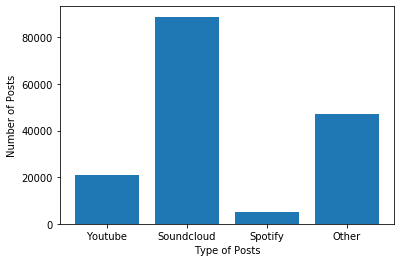

In [4]:
total = len(rtrap_df)
yt = rtrap_df['Url'].str.contains(r'youtube').sum()
sc = rtrap_df['Url'].str.contains(r'soundcloud').sum()
sp = rtrap_df['Url'].str.contains(r'spotify').sum()

plt.bar(['Youtube', 'Soundcloud', 'Spotify', 'Other'], 
        [yt, sc, sp, total-(yt+sc+sp)])
plt.ylabel('Number of Posts')
plt.xlabel('Type of Posts')
plt.show()

Quick clean up of all titles such as stripping white spaces, removing artifacts, and replacing artists with dashes and variations in their names. 

In [5]:
rtrap_df['Title'] = rtrap_df['Title'].str.strip()
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'amp;', '') # remove ampersand artifact
rtrap_df['Title'] = rtrap_df['Title'].str.upper() # normalize string to all uppercase
# handle unique artist cases
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(KRNE)', 'KRANE') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(HUDSON MOHAWK)', 'HUDSON MOHAWKE') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(XVII)', 'VINCENT') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(JACK Ü)', 'JACK U') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(G-JONES)', 'G JONES')
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(G-REX)', 'G REX')
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(G-DRAGON)', 'G DRAGON')
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(G-BUCK)', 'G BUCK')
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(G-EAZY)', 'G EAZY')
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(MR CARMACK)|(MR•CAR/\\ACK)', 'MR. CARMACK') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(T-PAIN)', 'T PAIN') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(A-TRAK)', 'A TRAK') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(TYNVN)', 'TYNAN') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(1788-L)', '1788L') 
rtrap_df['Title'] = rtrap_df['Title'].str.replace(r'(︻╦╤─ ƱZ ─╤╦︻)|(ƱZ)', 'UZ') 

In [6]:
rtrap_df['Date Created'] = rtrap_df['Date Created'].str[:10] # remove h:m:s in datetime

The assumption above for the title of posts is the simpliest case. The reality is that there are varying combinations that include flairs, multiple artists, and remixes that all need to be considered. An example would be:

[THROWBACK] Calvin Harris - Summer (Diplo & Grandtheft Remix). 

In this case, we need to strip the flair out of the title, and recognize that the track is a remix and need to be credited to the artists who made the remix, not the original artist. In-line comments below offer more detailed explanations of the cleaning process.

In [7]:
front = re.compile(r'(.+?(?=( )?-))') # regex to get all before "-" (artist)
flairs = '[FREE]', '[TRAP]', '[THROWBACK]', '[DUBSTEP]', '[FRESH]', '[DUBSTEP ELEMENTS]'
flairs_pattern = '|'.join(map(re.escape, flairs)) # regex to look for to remove flairs
collabs = ' & ', ' + ', ' X ', 'FT. ', 'FEAT. ', ', '
collabs_pattern = '|'.join(map(re.escape, collabs)) # regex to look for for multiple artists 

back = re.compile(r'((?<=- ).*)') # regex to get all after "-" (track)
# regex to get track name before any parantheses indicating a remix/edit/flip/vip
track_before_parans_pattern = re.compile(r'(.+?(?=(\((.+?)\))|(\[(.+?)\])))') 
remix_paran_pattern = re.compile(r'(\((.+?)\))|(\[(.+?)\])') # regex to get string in parantheses
remixes = 'REMIX', 'EDIT', 'FLIP', 'VIP'
# regex to get artist name that is between an open parathesis and string
artist_extract_pattern = re.compile(r'((?<=(\[|\())(.*?)(?=( VIP)|( REMIX)|( FLIP)|( EDIT)))')

for index, row in rtrap_df.iterrows():    
    artist = []
    front_part = front.search(row[1])
    # if title is in ARTIST - TRACK format, remove flairs and extra parantheses, thus keeping pure ARTIST string
    if front_part is not None: 
        front_part = re.sub(flairs_pattern, '', front_part.group(0))
        front_part = front_part.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        # if there exists any of the strings in the collabs list indicating multiple artists, split by those strings.
        # else, just append to artist list
        if any(collab in front_part for collab in collabs):
            split = re.split(collabs_pattern, front_part)
            for s in split:
                artist.append(s.strip())
                
        else:
            artist.append(front_part.strip())
    
    track = []
    back_part = back.search(row[1])
    # if title is in ARTIST - TRACK format, extract everything in the TRACK section of string
    if back_part is not None:
        remix_extract = re.search(remix_paran_pattern, back_part.group(0))
        # if found parantheses in the TRACK section of string, look for track name before paranthesis
        if remix_extract:
            track_extract = re.search(track_before_parans_pattern, back_part.group(0))
            # if track name does exist, append to track list 
            if track_extract:
                track.append(track_extract.group(0).strip())
            # if any of the remix strings exist in the string in the parantheses, look for artist name before string
            if any(remix in remix_extract.group(0) for remix in remixes):
                artist_extract = re.search(artist_extract_pattern, remix_extract.group(0))
                # if artist name does exist, replace original artist(s) i.e. give credit to the remix artist
                if artist_extract:
                    artist = [artist_extract.group(0).strip()]
        else:
            track.append(back_part.group(0).strip())
    
    rtrap_df.at[index, 'Artist'] = artist
    rtrap_df.at[index, 'Track'] = track
    

Check the output "Artist" and "Track" columns to the right.

In [8]:
rtrap_df.head()

,Submission ID,Title,Url,Author,Score,Body Text,Date Created,Date Created UTC,Comments,Permalink,Artist,Track
0,tybhx,HUDSON MOHAWKE - GOOO,http://www.youtube.com/watch?v=wh947EV_dyM,cc132,8,NaN,2012-05-21,1337642639,1,/r/trap/comments/tybhx/hudson_mohawk_gooo/,HUDSON MOHAWKE,GOOO
1,tybj9,BAAUER - HARLEM SHAKE,http://www.youtube.com/watch?v=Bk1_DbbzSdY,cc132,21,NaN,2012-05-21,1337642672,1,/r/trap/comments/tybj9/baauer_harlem_shake/,[BAAUER],[HARLEM SHAKE]
2,tyblt,THREE SIX MAFIA - RAINBOW COLORS,http://www.youtube.com/watch?v=5nyZ7rx9-Cc,cc132,0,NaN,2012-05-21,1337642746,0,/r/trap/comments/tyblt/three_six_mafia_rainbow...,[THREE SIX MAFIA],[RAINBOW COLORS]
3,tybn2,CARACAL - ELEMENTS,http://www.youtube.com/watch?v=ZZTu0nVYDRg,cc132,2,NaN,2012-05-21,1337642781,0,/r/trap/comments/tybn2/caracal_elements/,[CARACAL],[ELEMENTS]
4,tybog,LOL GURLZ - PUSSY OUT THE SHOWER HA,http://soundcloud.com/lolgurlz4real/lolgurlz-p...,[deleted],0,NaN,2012-05-21,1337642827,0,/r/trap/comments/tybog/lol_gurlz_pussy_out_the...,[LOL GURLZ],[PUSSY OUT THE SHOWER HA]


Let's see how many unique artists users posted by iterating through the "Artist" column and create a list of all artists. To filter out some noise, a threshold of 15 is set so only artists who were consistently being shared are included. In other words, only artists who have had tracks that were shared by users in the subreddit over 15 times are included in the list.

In [9]:
all_artists = []
for index,row in rtrap_df.iterrows():    
    if isinstance(row[10], list):
        for artist in row[10]:
            all_artists.append(artist)
    else:
        all_artists.append(row[10])

In [10]:
unique_artists = set(all_artists)

In [11]:
threshold = 15
artist_counts = {artist:all_artists.count(artist) for artist in unique_artists if all_artists.count(artist) > threshold}

In [12]:
print(len(artist_counts)) # unique artists

1135


Here we can quickly see the top 20 most-posted artists of the subreddit and that users had shared over 700 tracks related to RL Grime.

In [13]:
count = Counter(artist_counts)
for k, v in count.most_common(20):
    print('%s: %i' % (k, v))

RL GRIME: 712
MR. CARMACK: 597
BAAUER: 438
NGHTMRE: 390
FLOSSTRADAMUS: 387
SKRILLEX: 376
WHAT SO NOT: 345
QUIX: 343
UZ: 339
YELLOW CLAW: 337
TROYBOI: 313
FLUME: 291
HOLLY: 284
DJ SNAKE: 276
KRANE: 265
DILLON FRANCIS: 262
DIPLO: 259
GTA: 252
BOOMBOX CARTEL: 250
EKALI: 239


To look at how many total upvotes users gave to each artist, we can loop through each row of the dataframe and sum up the upvotes of each post that is related to each artist. We can see that RL Grime has the most upvotes at 40,345.

In [14]:
artist_votes = {}
for index,row in rtrap_df.iterrows():    
    if isinstance(row[10], list):
        for artist in row[10]:
            if artist not in artist_votes:
                artist_votes[artist] = row[4]
            else:
                artist_votes[artist] = artist_votes[artist] + row[4]
    else:
            if artist not in artist_votes:
                artist_votes[artist] = row[4]
            else:
                artist_votes[artist] = artist_votes[artist] + row[4]


In [15]:
votes = Counter(artist_votes)
for k, v in votes.most_common(20):
    print('%s: %i' % (k, v))

RL GRIME: 40345
BAAUER: 15015
WHAT SO NOT: 14714
EKALI: 14279
SKRILLEX: 13391
MR. CARMACK: 12566
FLUME: 12173
NGHTMRE: 11393
QUIX: 9602
UZ: 9370
TROYBOI: 8964
KRANE: 7940
BOOMBOX CARTEL: 7824
DILLON FRANCIS: 7814
FLOSSTRADAMUS: 7226
DJ SNAKE: 7221
GTA: 6977
YELLOW CLAW: 6841
MURA MASA: 6807
GETTER: 6625


We can now create a dictionary of stats of each artist, including the vote/track ratio. 

In [16]:
artist_stats = {}
for artist in artist_counts.keys():
    artist_stats[artist] = {'Tracks': artist_counts[artist], 
                            'Votes': artist_votes[artist], 
                            'Vote/Track': round(artist_votes[artist]/artist_counts[artist], 2)}

In [17]:
for key, value in sorted(artist_stats.items(), key=lambda item: item[1]['Vote/Track'], reverse=True):
    print("%s: %s" % (key, value))

RICH CHIGGA: {'Tracks': 22, 'Votes': 2354, 'Vote/Track': 107.0}
SHAWN WASABI: {'Tracks': 21, 'Votes': 2005, 'Vote/Track': 95.48}
PINK GUY: {'Tracks': 21, 'Votes': 1290, 'Vote/Track': 61.43}
EKALI: {'Tracks': 239, 'Votes': 14279, 'Vote/Track': 59.74}
RL GRIME: {'Tracks': 712, 'Votes': 40345, 'Vote/Track': 56.66}
VINCE STAPLES: {'Tracks': 23, 'Votes': 1157, 'Vote/Track': 50.3}
DOG BLOOD: {'Tracks': 18, 'Votes': 849, 'Vote/Track': 47.17}
ZHU: {'Tracks': 82, 'Votes': 3512, 'Vote/Track': 42.83}
WHAT SO NOT: {'Tracks': 345, 'Votes': 14714, 'Vote/Track': 42.65}
KNIFE PARTY: {'Tracks': 39, 'Votes': 1638, 'Vote/Track': 42.0}
FLUME: {'Tracks': 291, 'Votes': 12173, 'Vote/Track': 41.83}
VINCENT: {'Tracks': 152, 'Votes': 6310, 'Vote/Track': 41.51}
DELAY.: {'Tracks': 22, 'Votes': 884, 'Vote/Track': 40.18}
OG MACO: {'Tracks': 16, 'Votes': 639, 'Vote/Track': 39.94}
STÖÖKI SOUND: {'Tracks': 37, 'Votes': 1416, 'Vote/Track': 38.27}
EPROM: {'Tracks': 127, 'Votes': 4750, 'Vote/Track': 37.4}
HEX COUGAR: {'T

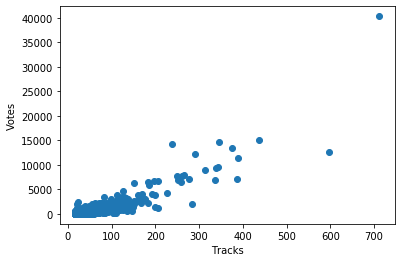

In [18]:
x = [artist_stats[artist]['Tracks'] for artist in artist_stats]
y = [artist_stats[artist]['Votes'] for artist in artist_stats]
plt.xlabel('Tracks')
plt.ylabel('Votes')
plt.scatter(x, y)
plt.show()

We need to get our data into a specific format so we can upload it to Flourish for our animated chart. Let's only consider the top 100 most upvoted artists. 

In [19]:
# get top 100 most voted artists
top_100_voted = [k for k, v in votes.most_common(100)]

Since the racing bar chart shows progression over time, we need to split our data by a certain time frame. Here, its is generating a list of dates from 2012/05/01 to 2020/05/16 by month for our new dataframe.

In [20]:
daterange = pd.date_range('2012-05-01','2020-05-16', freq='MS').strftime("%Y-%m-%d").tolist()
print(daterange)
len(daterange)

['2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018

97

In [21]:
df1 = pd.DataFrame(top_100_voted, columns=['Artist'])
df2 = pd.DataFrame([], columns=daterange)

In [22]:
racing_chart_df = pd.concat([df1, df2], axis=1)
racing_chart_df.head()

,Artist,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,...,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01
0,RL GRIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAAUER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WHAT SO NOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EKALI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SKRILLEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To fill in each cell, we can separate the original dataframe into chunks with the before and after dates we specified previously, loop through each row, and sum up all upvotes given to each artist. At the end of each loop/chunk, the rolling sum of upvotes is set to the specific month column and index of the artist name in the new dataframe.

In [23]:
l = len(daterange)
rolling_sum = {}
for index, d in enumerate(daterange):
    after = d
    if index+1 == l:
        before = '2099-01-01'
    else:
        before = str(datetime.datetime.strptime(daterange[index + 1], '%Y-%m-%d') - datetime.timedelta(days=1))
    temp_df = rtrap_df[rtrap_df['Date Created'].between(after, before)]
    for j, row in temp_df.iterrows():
        if isinstance(row[10], list):
            for artist in row[10]:
                if artist in top_100_voted:
                    if artist not in rolling_sum:
                        rolling_sum[artist] = row[4]
                    else:
                        rolling_sum[artist] += row[4]
        else:
            if artist in top_100_voted:
                    if artist not in rolling_sum:
                        rolling_sum[artist] = row[4]
                    else:
                        rolling_sum[artist] += row[4]

    for a in rolling_sum: 
        idx = racing_chart_df.loc[racing_chart_df['Artist'] == a].index[0]
        racing_chart_df.at[idx, after] = rolling_sum[a]              
                        

Finally, we do a quick sanity check of the total number of upvotes for each artist, fill in blanks with zeros, and export and upload the final dataframe to Flourish.

The animation can be viewed here:

https://public.flourish.studio/visualisation/2415828/

In [24]:
racing_chart_df.head()

,Artist,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,...,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01
0,RL GRIME,NaN,1,1,10,36,126,127,172,210,...,36617,36791,40324,40336,40338,40338,40340,40342,40343,40345
1,BAAUER,21,109,383,483,614,727,809,987,1697,...,14849,14849,14992,14992,14994,14994,14994,14995,15009,15015
2,WHAT SO NOT,NaN,NaN,NaN,54,54,54,56,58,69,...,14554,14706,14706,14707,14709,14711,14711,14713,14714,14714
3,EKALI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14039,14201,14264,14269,14269,14274,14278,14278,14278,14279
4,SKRILLEX,NaN,NaN,NaN,0,0,0,0,0,0,...,13245,13289,13290,13290,13296,13385,13387,13390,13391,13391


In [25]:
racing_chart_df.fillna(0, inplace=True)
racing_chart_df.to_excel(r'racing_chart.xlsx')

In [26]:
rtrap_df.to_csv('rtrap-2012-5-20-2020-5-15[CLEANED].csv')